In [5]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

def evaluate_and_plot_mlp(
    model_path: str,
    hidden_dims: list[int],
    activations: list[str],
    test_csv: str,
    sample_index: int = None
):
    """
    Load a trained MLP (for all inputs except Input 12), evaluate on test data,
    and plot:
      1) Error histogram
      2) True vs Predicted scatter
      3) If sample_index >=0: sweep Input 10 for that sample
         If sample_index <0 or None: do sweep for all samples in 3-per-row grid.
    """
    # 1) Load test data
    df = pd.read_csv(test_csv)
    for c in ('F2','F3'):
        if c in df: df.drop(columns=[c], inplace=True)
    y_true = df['Output'].to_numpy(dtype=float)

    # 2) Build feature matrix X (Inputs 1–18 except 12)
    all_inputs = [f'Input {i}' for i in range(1,19) if i != 12]
    X = df[all_inputs].copy()

    # 3) Encode categorical Inputs 1–8
    categories_map = {
        'Input 1': [1,2],
        'Input 2': list(range(1,6)),
        'Input 3': list(range(1,6)),
        'Input 4': list(range(1,22)),
        'Input 5': list(range(1,6)),
        'Input 6': [1,2,3],
        'Input 7': [1,2,3,4],
        'Input 8': list(range(1,11)),
    }
    for col, cats in categories_map.items():
        if col not in X.columns: continue
        if len(cats) == 2:
            X[col] = X[col].map({cats[0]: +1.0, cats[1]: -1.0})
        else:
            X[col] = pd.Categorical(X[col], categories=cats)
            dummies = pd.get_dummies(X[col], prefix=col)
            for c in cats:
                key = f"{col}_{c}"
                if key not in dummies.columns:
                    dummies[key] = 0
            X = pd.concat([X.drop(columns=[col]), dummies], axis=1)

    # 4) Normalize numeric inputs (9–18 except 12)
    numeric_inputs = [f'Input {i}' for i in range(9,19) if i != 12]
    means = X[numeric_inputs].mean()
    stds  = X[numeric_inputs].std().replace(0,1.0)
    X[numeric_inputs] = (X[numeric_inputs] - means) / stds

    X_np = X.to_numpy(dtype=np.float32)

    # 5) Normalize target
    y_mean, y_std = y_true.mean(), (y_true.std() if y_true.std() != 0 else 1.0)
    y_norm = (y_true - y_mean) / y_std

    # 6) Reconstruct and load model
    class MLPNet(nn.Module):
        def __init__(self, in_dim, hidden_dims, activations):
            super().__init__()
            layers = []
            dims = [in_dim] + hidden_dims
            for i, hd in enumerate(hidden_dims):
                layers.append(nn.Linear(dims[i], dims[i+1]))
                act = activations[i].lower()
                if act == 'relu':
                    layers.append(nn.ReLU())
                elif act == 'tanh':
                    layers.append(nn.Tanh())
                elif act == 'sigmoid':
                    layers.append(nn.Sigmoid())
                elif act == 'softplus':
                    layers.append(nn.Softplus())
                else:
                    raise ValueError(f"Unknown activation '{activations[i]}'")
            layers.append(nn.Linear(dims[-1], 1))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLPNet(X_np.shape[1], hidden_dims, activations).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 7) Predict
    with torch.no_grad():
        X_t = torch.from_numpy(X_np).to(device)
        y_pred_norm = model(X_t).cpu().numpy().flatten()
    y_pred = y_pred_norm * y_std + y_mean

    # 8) Error histogram
    plt.figure(figsize=(8,5))
    plt.hist(y_pred - y_true, bins=30, edgecolor='k')
    plt.title("Error Histogram")
    plt.xlabel("Predicted – True")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # 9) True vs Predicted scatter
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6, label='All samples')
    mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], 'k--', label='45° line')
    if sample_index is not None and sample_index >= 0:
        plt.scatter(
            [y_true[sample_index]],
            [y_pred[sample_index]],
            color='red', s=80, label=f"Sample {sample_index}"
        )
    plt.title("True vs Predicted")
    plt.xlabel("True Output")
    plt.ylabel("Predicted Output")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 10) Sample-sweep helper
    x10 = df["Input 10"].to_numpy(dtype=float)
    mu10, sig10 = means["Input 10"], stds["Input 10"]
    def plot_sample(i, ax):
        Xi = X_np[i].copy()
        xi, yi = x10[i], y_true[i]
        grid = np.linspace(0, 3000, 300)
        gn = (grid - mu10 * sig10 - mu10 + mu10 * sig10) / sig10  # simplified: (grid - mu10)/sig10
        # Actually use:
        gn = (grid - mu10)/sig10
        # create repeated feature rows
        Xr = np.tile(Xi, (300,1))
        # replace normalized Input 10 column
        idx10 = all_inputs.index("Input 10")
        Xr[:, idx10] = gn
        with torch.no_grad():
            pr = model(torch.from_numpy(Xr).to(device)).cpu().numpy().flatten()
        pr = pr * y_std + y_mean
        ax.plot(grid, pr)
        ax.scatter(xi, yi, color='red', zorder=5)
        ax.set_xlim(0,3000)
        ax.set_ylim(-65000,100000)
        ax.set_xticks([0,3000])
        ax.set_yticks([-65000,100000])
        ax.set_title(f"Sample {i}")
        ax.set_xlabel("Input 10")
        ax.set_ylabel("Output")

    # 11) Plot sample sweeps
    n = len(y_true)
    if sample_index is not None and 0 <= sample_index < n:
        fig, ax = plt.subplots(figsize=(12,8))
        plot_sample(sample_index, ax)
        plt.tight_layout()
        plt.show()
    else:
        cols = 3
        rows = int(np.ceil(n/cols))
        fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*6))
        axs = axs.flatten()
        for i in range(n):
            plot_sample(i, axs[i])
        for j in range(n, len(axs)):
            fig.delaxes(axs[j])
        plt.tight_layout()
        plt.show()


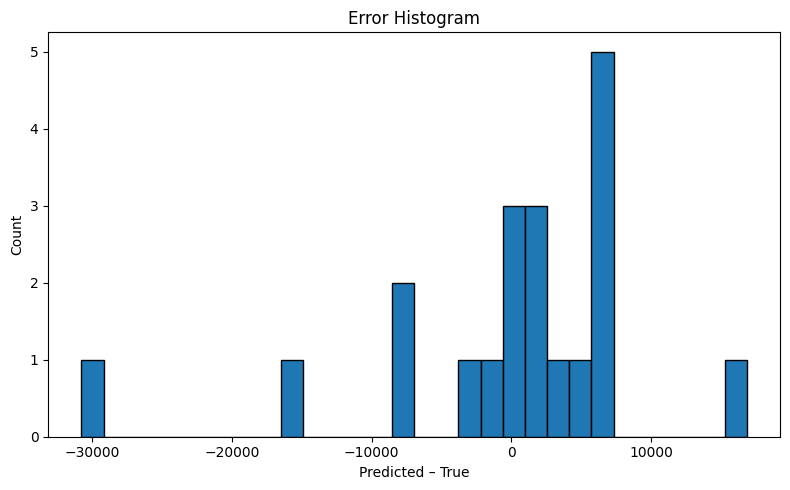

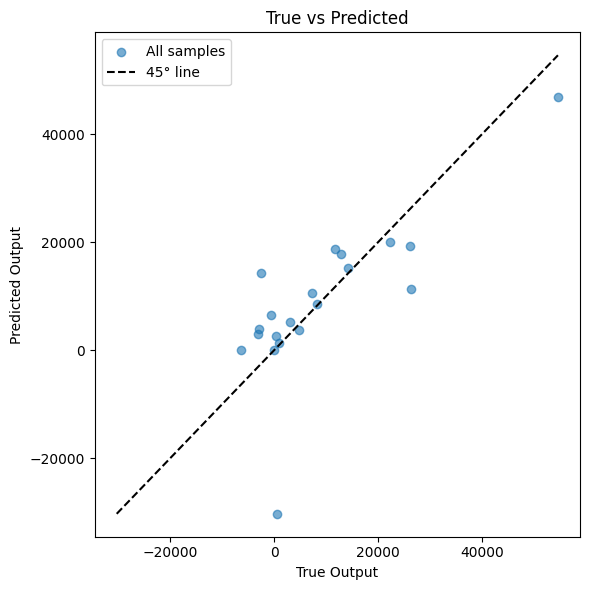

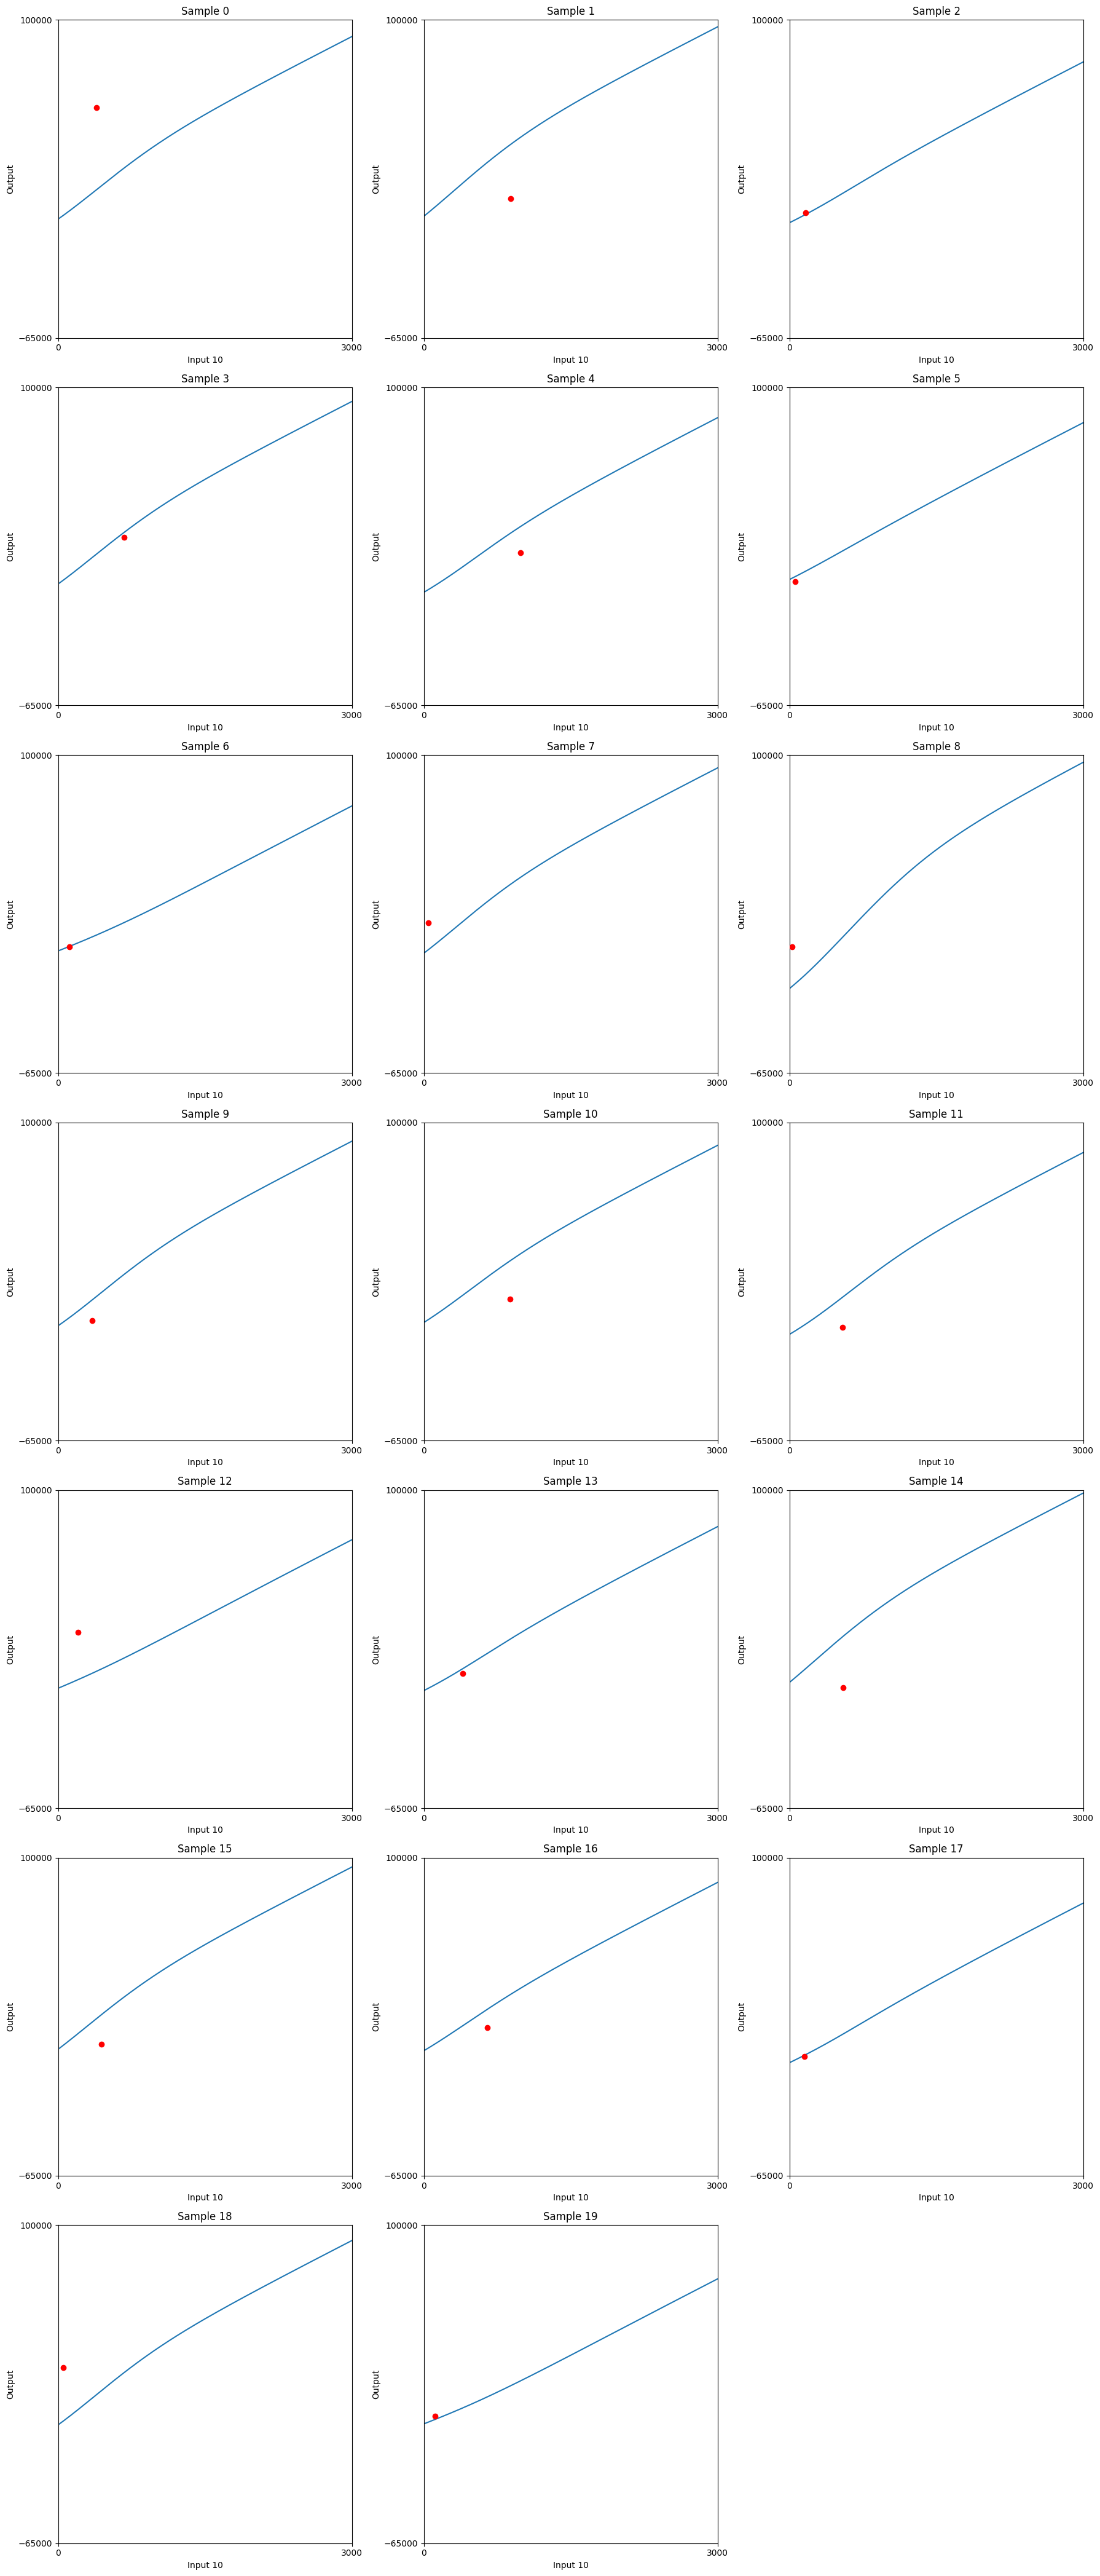

In [6]:
evaluate_and_plot_mlp(
    model_path="/home/kamiar/chevron/Acid-neural-net/First Data-V2/NoPoly/b7f5ebbb/b7f5ebbb_fold7.pth",
    hidden_dims=[4,4],
    activations=['softplus','softplus'],
    test_csv="/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/test.csv",
    sample_index=None   # or None to skip highlighting
)